In [13]:
import rebound
%matplotlib inline
import matplotlib.pyplot as plt
import observations
import state
import mcmc
import numpy as np
import corner
from ipywidgets import FloatProgress
from IPython.display import display

# Setting up fake observations

In [14]:
true_state = state.State(planets=[{"m":1e-3, "a":1., "h":0.2, "k":0.0, "l":0.},{"m":1e-3, "a":1.6}])
obs = observations.FakeObservation(true_state, Npoints=100, error=1e-4, tmax=10.)

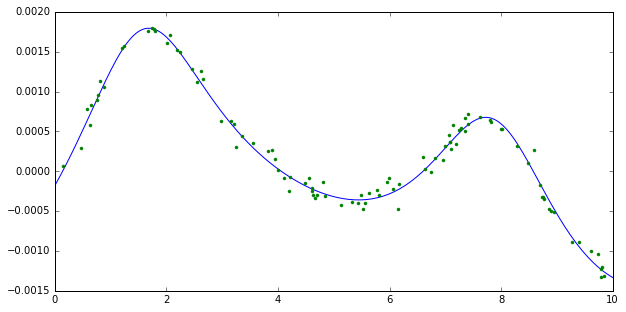

In [15]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.plot(*true_state.get_rv_plotting(tmax=10.))
ax.plot(obs.t, obs.rv, ".")

# PalEns 
Starting from exact solution.

In [19]:
Nwalkers = 6
palens = mcmc.PalEns(true_state,obs,scales={"m":1e-3, "a":1., "h":0.5, "k":0.5, "l":np.pi},nwalkers=Nwalkers)
Niter = 100
chain = np.zeros((Niter,Nwalkers,palens.state.Nvars))
chainlogp = np.zeros((Niter,Nwalkers))
tries = 0
f = FloatProgress(min=0, max=Niter)
display(f)
for i in range(Niter):
    tries += palens.step_force()
    for k in range(Nwalkers):
        chain[i][k] = palens.states[k].get_params()
        chainlogp[i][k] = palens.states[k].logp
    f.value = i
print("Acceptance rate: %.2f%%"%(float(Niter)/tries*100))

Acceptance rate: 54.05%


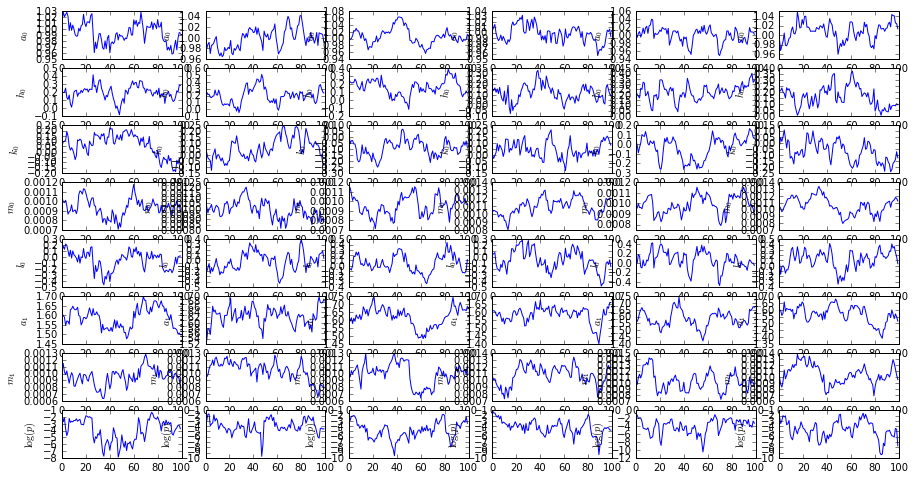

In [20]:
f, axs = plt.subplots(true_state.Nvars+1,Nwalkers,figsize=(15,8))
for i in range(true_state.Nvars):
    for k in range(Nwalkers):
        ax = axs[i,k]
        ax.set_ylabel(true_state.get_keys()[i])
        ax.plot(chain[:,k,i])
for k in range(Nwalkers):
    ax = axs[true_state.Nvars,k]
    ax.set_ylabel("$\log(p)$")
    ax.plot(chainlogp[:,k])    

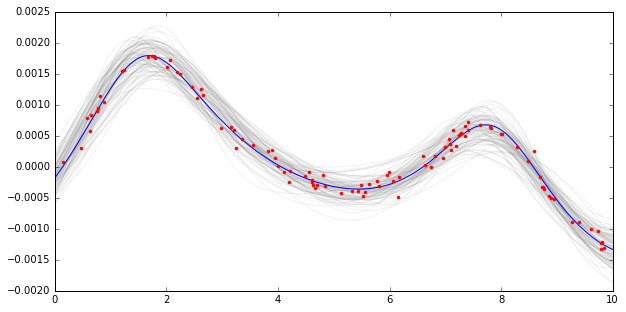

In [21]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
for c in np.random.choice(Niter,100):
    k = np.random.randint(Nwalkers)
    s = palens.state.deepcopy()
    s.set_params(chain[c,k])
    ax.plot(*s.get_rv_plotting(tmax=10.), alpha=0.1, color="gray")
ax.plot(*true_state.get_rv_plotting(tmax=10.), color="blue")
ax.plot(obs.t, obs.rv, "r.")    

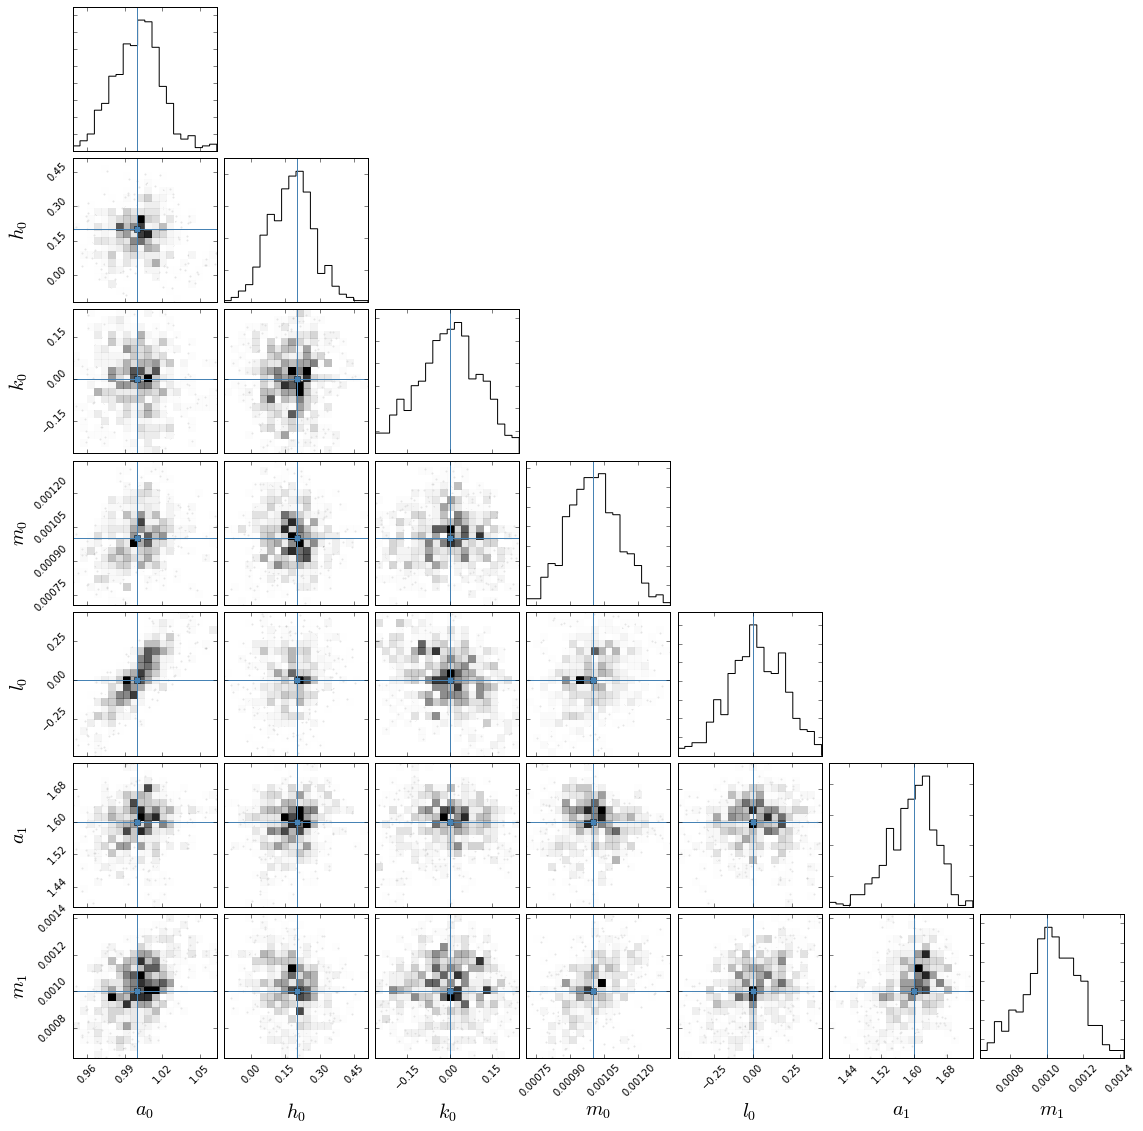

In [22]:
figure = corner.corner(np.reshape(chain,(Nwalkers*Niter,true_state.Nvars)), labels=s.get_keys(), plot_contours=False, truths=true_state.get_params(),label_kwargs={"fontsize":20})